# Task 1b: Consumer Flexibility with Discomfort Minimization

## Problem Description

We now consider that the consumer described in Question 1a does not have a strict daily energy consumption requirement. Instead, it is interested in minimizing the discomfort incurred from shifting its flexible load at each hour compared to a reference hourly load profile, in addition to minimizing its energy procurement cost through the day. We analyze the impact on its flexibility and profits.

### Task 1b Objectives

Building upon Task 1a, this model introduces:
- **Discomfort cost modeling**: Penalize deviations from preferred consumption patterns
- **Load deviation variables**: Track upward and downward deviations from reference load
- **Flexible daily consumption**: Remove strict minimum daily consumption constraint
- **Preference-based optimization**: Balance economic efficiency with consumer comfort

### Key Model Changes from Task 1a

1. **Removed**: Daily minimum consumption constraint (∑ₜ lₜ ≥ L_min)
2. **Added**: Deviation variables d⁺ₜ (upward) and d⁻ₜ (downward) 
3. **Added**: Load deviation constraint: lₜ - d⁺ₜ + d⁻ₜ = L_ref_t
4. **Added**: Discomfort cost terms in objective function

### Analysis Framework

We will analyze:
- **Sensitivity to discomfort costs**: How parameter κ affects load shifting behavior
- **Trade-offs**: Economic savings vs consumer comfort
- **Scenario comparison**: Impact across different pricing structures
- **Flexibility patterns**: How preferences shape optimal consumption

## Notebook Outline

1. **Setup**: Import libraries and 
2. **Data Loading**: load Task 1b parameters
2. **Model Formulation**: Build LP model with deviation variables and discomfort costs
3. **Sensitivity Analysis**: Analyze impact of discomfort cost parameter κ
4. **Scenario Analysis**: Run optimization across different pricing scenarios
5. **Results Visualization**: Plot energy flows, deviations, and dual variables
6. **Comparative Analysis**: Multi-scenario summary and insights

## 1. Setup & Dependencies

Import required libraries for optimization, data processing, and visualization.

In [1]:
import json
from pathlib import Path
from dataclasses import dataclass, field
from typing import Dict, List, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gurobipy as gp
from gurobipy import GRB

Load utility modules for data handling, plotting, optimization classes, and helper functions.

In [2]:
import utils.data as data
import utils.plots as plots
import utils.classes as classes
import utils.helpers as helpers

## 2. Data Configuration

Set the data directory for Task 1b input parameters. Note that Task 1b uses the same physical parameters as Task 1a but introduces reference load profiles for discomfort modeling.

In [3]:
DATA_DIR = Path("data/question_1b")

## 3. Model Formulation

### Linear Programming Model for Task 1b

The optimization model balances energy procurement cost and discomfort from load shifting.

**Decision Variables:**
- `l[t]`: Load consumption in hour t (kWh) 
- `p[t]`: PV self-consumption in hour t (kWh)
- `e[t]`: Grid imports in hour t (kWh)
- `s[t]`: PV exports in hour t (kWh) 
- `c[t]`: PV curtailment in hour t (kWh)
- `d+[t]`: Upward deviation from reference load in hour t (kWh)
- `d-[t]`: Downward deviation from reference load in hour t (kWh)

**Objective Function:**
Minimize: ∑ₜ [(πₜ + τᵢᵐᵖ)·eₜ - (πₜ - τᵉˣᵖ)·sₜ + κ·πₜ·(d⁺ₜ + d⁻ₜ)]

Where κ is the discomfort cost multiplier (default 1.3).

**Constraints:**
1. **Hourly load balance**: lₜ = pₜ + eₜ  ∀t
2. **PV allocation**: pₜ + sₜ + cₜ = P^PV_t  ∀t  
3. **Load capacity**: lₜ ≤ l_max  ∀t
4. **Load deviation**: lₜ - d⁺ₜ + d⁻ₜ = L_ref_t  ∀t

**Key Changes from Task 1a:**
- Removed daily minimum consumption constraint
- Added deviation variables and constraint
- Added discomfort cost terms weighted by κ

In [4]:
def build_input_data_1b(base, scenario, kappa=1.3):
    T = base["T"]
    price = scenario["price"]
    imp   = scenario["imp"]
    exp   = scenario["exp"]
    P_pv  = base["P_pv"]
    l_max_hour = base["l_max_hour"]
    # Get the reference load profile
    L_ref = base["L_ref"]

    # --- 1. Define New Variables ---
    # Add d+[t] (upward deviation) and d-[t] (downward deviation)
    VARIABLES = []
    for t in range(T):
        VARIABLES += [f"l[{t}]", f"p[{t}]", f"e[{t}]", f"s[{t}]", f"c[{t}]", f"d+[{t}]", f"d-[{t}]"]

    # --- 2. Update Objective Function ---
    objective_coeff = {v: 0 for v in VARIABLES}
    for t in range(T):
        # Energy costs (same as before)
        objective_coeff[f"e[{t}]"] = price[t] + imp[t]
        objective_coeff[f"s[{t}]"] = -(price[t] - exp[t])
        
        # Add discomfort cost (using gamma_t = price_t * kappa)
        objective_coeff[f"d+[{t}]"] = price[t] * kappa 
        objective_coeff[f"d-[{t}]"] = price[t] * kappa 

    # --- Constraints ---
    constraints_coeff = {v: [] for v in VARIABLES}
    constraints_rhs = []
    constraints_sense = []

    # --- 3. REMOVE Daily Minimum Consumption Constraint ---
    # The L_min constraint block is deleted.

    # (1) Hourly load balance: l_t - p_t - e_t = 0 (Unchanged from 1a)
    for t in range(T):
        for v in VARIABLES:
            if v == f"l[{t}]": coeff = 1.0
            elif v == f"p[{t}]": coeff = -1.0
            elif v == f"e[{t}]": coeff = -1.0
            else: coeff = 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(0.0)
        constraints_sense.append(GRB.EQUAL)

    # (2) PV split: p_t + s_t + c_t = P^{PV}_t (Unchanged from 1a)
    for t in range(T):
        for v in VARIABLES:
            if v == f"p[{t}]": coeff = 1.0
            elif v == f"s[{t}]": coeff = 1.0
            elif v == f"c[{t}]": coeff = 1.0
            else: coeff = 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(P_pv[t])
        constraints_sense.append(GRB.EQUAL)

    # (3) Hourly max load: l_t <= l_max_hour (Unchanged from 1a)
    for t in range(T):
        for v in VARIABLES:
            if v == f"l[{t}]": coeff = 1.0
            else: coeff = 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(l_max_hour)
        constraints_sense.append(GRB.LESS_EQUAL)
        
    # --- 4. ADD Load Deviation Constraint ---
    # l_t - d+_t + d-_t = L_ref_t
    for t in range(T):
        for v in VARIABLES:
            if v == f"l[{t}]": coeff = 1.0
            elif v == f"d+[{t}]": coeff = -1.0
            elif v == f"d-[{t}]": coeff = 1.0
            else: coeff = 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(L_ref[t])
        constraints_sense.append(GRB.EQUAL)

    print(type(P_pv[0]), P_pv[0])
    print(type(L_ref[0]), L_ref[0])
            
    return classes.InputData(VARIABLES, objective_coeff, constraints_coeff, constraints_rhs, constraints_sense)

## 4. Data Loading & Scenario Setup

Load input parameters and create different pricing scenarios. The Task 1b data includes reference load profiles that represent the consumer's preferred consumption pattern.

In [5]:
appliance_params, bus_params, consumer_params, der_prod, usage_pref = data.load_inputs(DATA_DIR)
base = data.prepare_base_inputs(appliance_params, bus_params, der_prod, usage_pref, task="b")
scenarios = data.make_scenarios(base)

## 5. Sensitivity Analysis

### Impact of Discomfort Cost Parameter κ

Analyze how the discomfort cost multiplier κ affects the trade-off between economic optimization and consumer comfort. Higher κ values make deviations more expensive, encouraging consumption patterns closer to the reference profile.

Running sensitivity analysis for kappa from 0.5 to 1.5...
<class 'numpy.float64'> 0.0
<class 'numpy.float64'> 0.165
Set parameter Username
Set parameter LicenseID to value 2625590
Academic license - for non-commercial use only - expires 2026-02-20
<class 'numpy.float64'> 0.0
<class 'numpy.float64'> 0.165
<class 'numpy.float64'> 0.0
<class 'numpy.float64'> 0.165
<class 'numpy.float64'> 0.0
<class 'numpy.float64'> 0.165
<class 'numpy.float64'> 0.0
<class 'numpy.float64'> 0.165
<class 'numpy.float64'> 0.0
<class 'numpy.float64'> 0.165
<class 'numpy.float64'> 0.0
<class 'numpy.float64'> 0.165
<class 'numpy.float64'> 0.0
<class 'numpy.float64'> 0.165
<class 'numpy.float64'> 0.0
<class 'numpy.float64'> 0.165
<class 'numpy.float64'> 0.0
<class 'numpy.float64'> 0.165
<class 'numpy.float64'> 0.0
<class 'numpy.float64'> 0.165
Analysis complete.


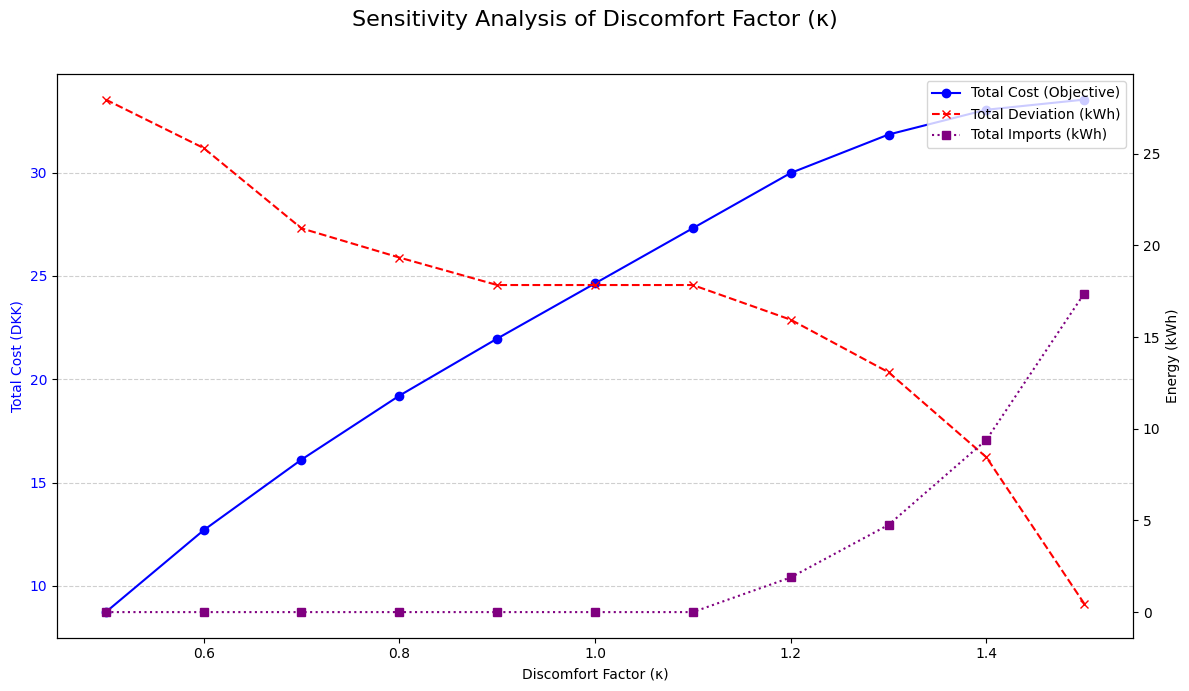

In [6]:
# --- SENSITIVITY ANALYSIS SETUP ---
# Define the range of kappa values to test
kappa_values = np.linspace(0.5, 1.5, 11) # 11 steps from 0.5 to 1.5
sensitivity_results = []

# Use the "Base" scenario for the analysis
sc = scenarios["Base"]

print(f"Running sensitivity analysis for kappa from {kappa_values.min()} to {kappa_values.max()}...")

# Loop through each kappa value
for kappa in kappa_values:
    # 1. Build input data with the current kappa
    input_data = build_input_data_1b(base, sc, kappa=kappa)
    
    # 2. Run optimization
    problem = classes.LP_OptimizationProblem(input_data)
    problem.model.setParam('OutputFlag', 0) # Suppress Gurobi output for cleaner loop
    problem.run()
    
    # 3. Extract and store the key results
    if problem.model.status == GRB.OPTIMAL:
        df = helpers.results_to_dataframe(problem.results, base["T"])
        result_summary = {
            "kappa": kappa,
            "Objective": problem.results.objective_value,
            "Total Deviation": df["d+"].sum() + df["d-"].sum(),
            "Total Imports": df["e"].sum(),
            "Total Exports": df["s"].sum(),
            "Total PV Self-Consumed": df["p"].sum()
        }
        sensitivity_results.append(result_summary)

# Convert the list of results into a DataFrame for easy plotting
sensitivity_df = pd.DataFrame(sensitivity_results).set_index("kappa")

print("Analysis complete.")
# display(sensitivity_df)
plots.plot_sensitivity_analysis_1b(sensitivity_df)

## 6. Scenario Analysis

### 6.1 Base Scenario

Standard pricing with import/export tariffs. Observe how the model balances energy costs with discomfort costs, allowing deviations from the reference load when economically beneficial.

<class 'numpy.float64'> 0.0
<class 'numpy.float64'> 0.165
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 96 rows, 168 columns and 240 nonzeros
Model fingerprint: 0x9a6cebe6
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 87 rows and 143 columns
Presolve time: 0.00s
Presolved: 9 rows, 25 columns, 27 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4152845e+01   9.345000e+00   0.000000e+00      0s
       7    3.1840845e+01   0.000000e+00   0.000000e+00      0s

Solved in 7 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.184084500e+01


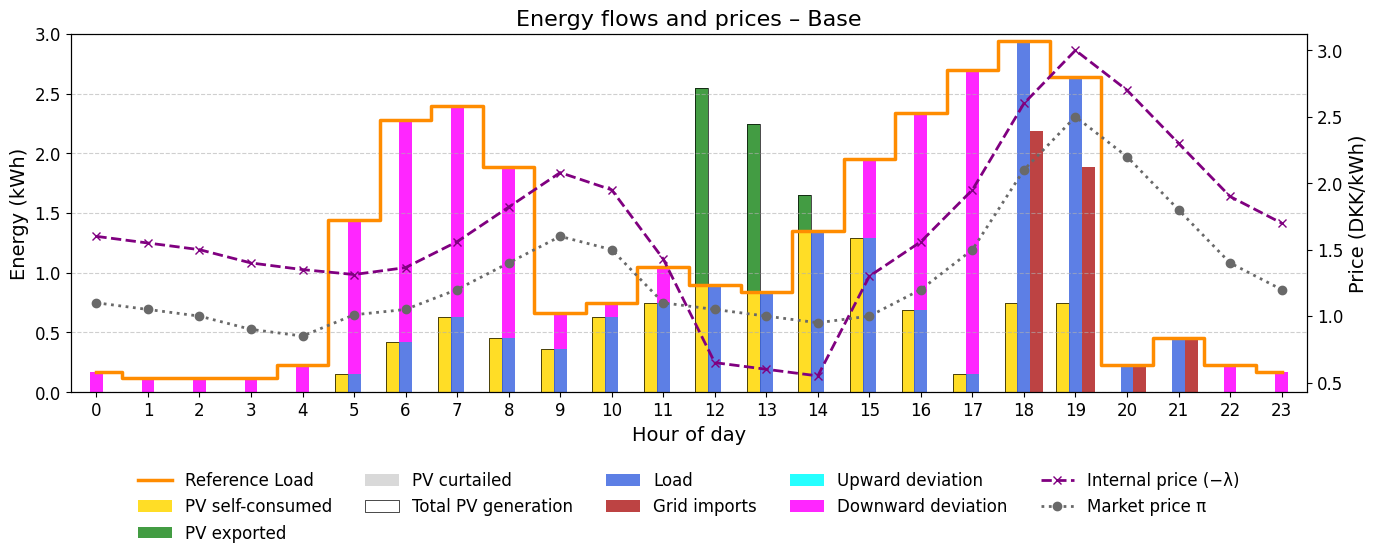

sum of load: 14.864999999999998


In [7]:
# --- Base scenario ---
scenario_name = "Base"
sc = scenarios[scenario_name]

# 1) Build input data
input_data = build_input_data_1b(base, sc)

# 2) Run optimization
problem = classes.LP_OptimizationProblem(input_data)
problem.run()

# 3) Convert results to DataFrame
df = helpers.results_to_dataframe(problem.results, base["T"])

# 4) Extract duals (λ_t for hourly balance constraints)
duals_lambda = [problem.results.duals[f"constr[{i}]"] for i in range(base["T"])]

num_constraints_before = 3 * base["T"] # (load balance + PV split + max load)
duals_delta = [problem.results.duals[f"constr[{i}]"] for i in range(num_constraints_before, num_constraints_before + base["T"])]

# 5) Plot
plots.plot_hourly_flows_with_prices_1b(
    df,
    scenario_name,
    duals=duals_lambda, # Use the correctly extracted duals
    price=sc["price"],
    alpha=sc["price"] + sc["imp"],
    beta=sc["price"] - sc["exp"],
    L_ref=base["L_ref"] 
)
print("sum of load:", df["l"].sum())

### 6.2 Constant Price Scenario

With flat pricing, load shifting incentives come purely from PV availability patterns. The model should show minimal deviations from reference load since temporal arbitrage opportunities are eliminated.

<class 'numpy.float64'> 0.0
<class 'numpy.float64'> 0.165
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 96 rows, 168 columns and 240 nonzeros
Model fingerprint: 0x7eb99eb6
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-01, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 93 rows and 159 columns
Presolve time: 0.00s
Presolved: 3 rows, 9 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.4656914e+01   3.090000e+00   0.000000e+00      0s
       3    2.7497139e+01   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.749713875e+01


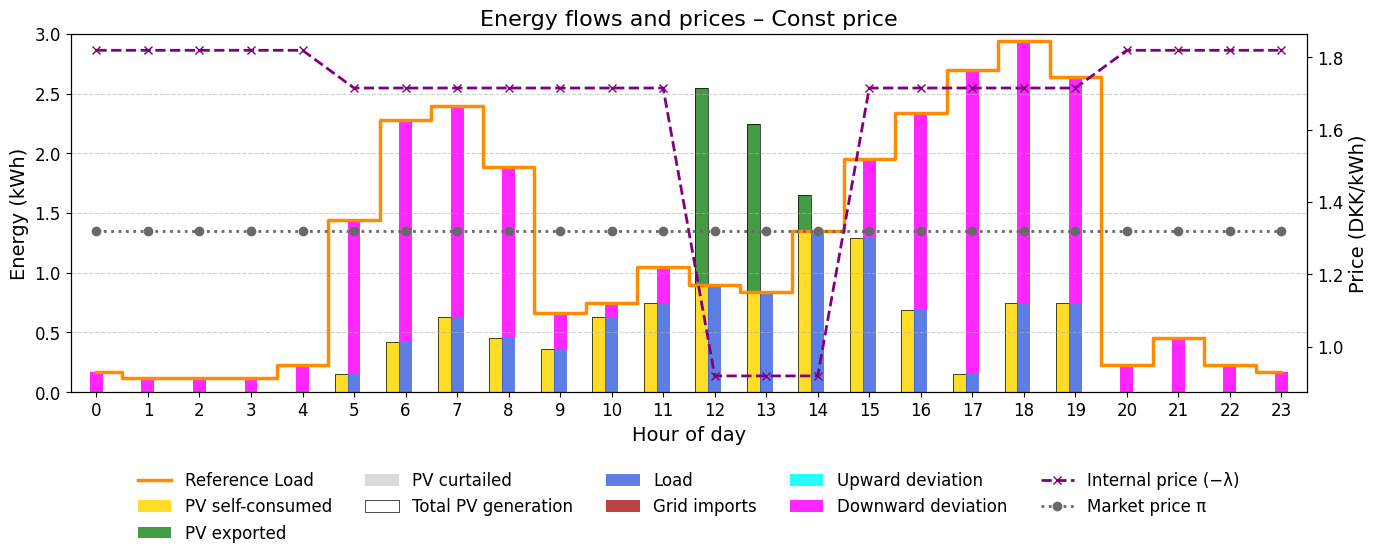

sum of load: 10.11


In [8]:
# --- Constant price scenario ---
scenario_name = "Const price"
sc = scenarios[scenario_name]

# 1) Build input data
input_data = build_input_data_1b(base, sc)

# 2) Run optimization
problem = classes.LP_OptimizationProblem(input_data)
problem.run()

# 3) Convert results to DataFrame
df = helpers.results_to_dataframe(problem.results, base["T"])

# 4) Extract duals (λ_t for hourly balance constraints)
duals_lambda = [problem.results.duals[f"constr[{i}]"] for i in range(base["T"])]

num_constraints_before = 3 * base["T"] # (load balance + PV split + max load)
duals_delta = [problem.results.duals[f"constr[{i}]"] for i in range(num_constraints_before, num_constraints_before + base["T"])]

# 5) Plot
plots.plot_hourly_flows_with_prices_1b(
    df,
    scenario_name,
    duals=duals_lambda, # Use the correctly extracted duals
    price=sc["price"],
    alpha=sc["price"] + sc["imp"],
    beta=sc["price"] - sc["exp"],
    L_ref=base["L_ref"] 
)
print("sum of load:", df["l"].sum())

### 6.3 Net Metering Scenario

Zero grid tariffs create perfect price symmetry. Compare deviation patterns with Base scenario to understand how tariff structures influence the balance between economic optimization and consumer comfort.

<class 'numpy.float64'> 0.0
<class 'numpy.float64'> 0.165
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 96 rows, 168 columns and 240 nonzeros
Model fingerprint: 0x338968e6
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 72 rows and 96 columns
Presolve time: 0.00s
Presolved: 24 rows, 72 columns, 72 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6612500e+01   2.794500e+01   0.000000e+00      0s
      24    2.3292150e+01   0.000000e+00   0.000000e+00      0s

Solved in 24 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.329215000e+01


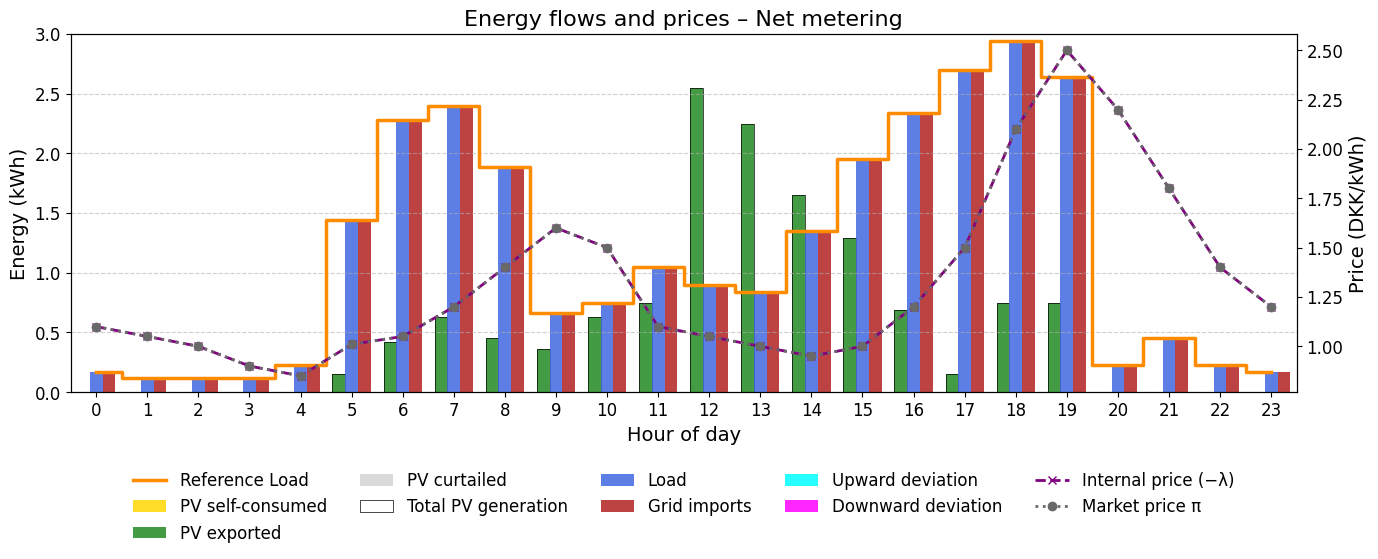

sum of load: 27.945


In [9]:
# --- Net metering scenario ---
scenario_name = "Net metering"
sc = scenarios[scenario_name]

# 1) Build input data
input_data = build_input_data_1b(base, sc)

# 2) Run optimization
problem = classes.LP_OptimizationProblem(input_data)
problem.run()

# 3) Convert results to DataFrame
df = helpers.results_to_dataframe(problem.results, base["T"])

# 4) Extract duals (λ_t for hourly balance constraints)
duals_lambda = [problem.results.duals[f"constr[{i}]"] for i in range(base["T"])]

num_constraints_before = 3 * base["T"] # (load balance + PV split + max load)
duals_delta = [problem.results.duals[f"constr[{i}]"] for i in range(num_constraints_before, num_constraints_before + base["T"])]

# 5) Plot
plots.plot_hourly_flows_with_prices_1b(
    df,
    scenario_name,
    duals=duals_lambda, # Use the correctly extracted duals
    price=sc["price"],
    alpha=sc["price"] + sc["imp"],
    beta=sc["price"] - sc["exp"],
    L_ref=base["L_ref"] 
)
print("sum of load:", df["l"].sum())

### 6.4 No Export Scenario

Unfavorable export pricing forces higher PV self-consumption. This should increase load deviations as the consumer shifts consumption to match PV availability, balancing avoided import costs against discomfort penalties.

<class 'numpy.float64'> 0.0
<class 'numpy.float64'> 0.165
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 96 rows, 168 columns and 240 nonzeros
Model fingerprint: 0x1c2ac517
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-02, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 87 rows and 143 columns
Presolve time: 0.00s
Presolved: 9 rows, 25 columns, 27 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0917845e+01   4.755000e+00   0.000000e+00      0s
       4    3.3924345e+01   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.392434500e+01


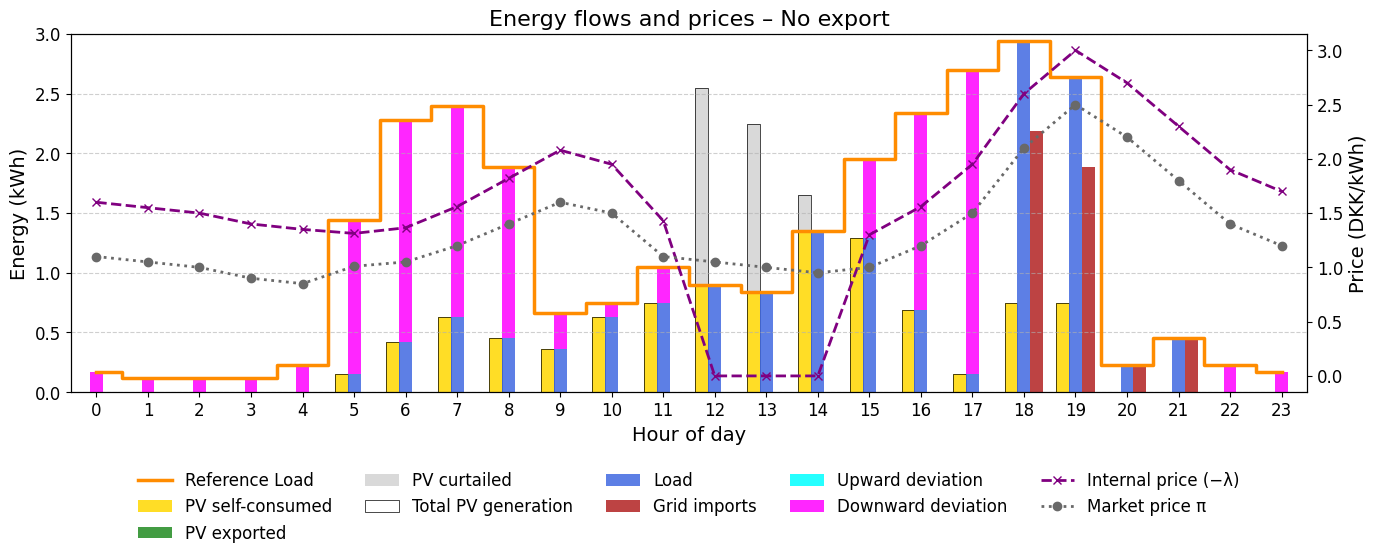

sum of load: 14.864999999999998


In [10]:
# --- No export scenario ---
scenario_name = "No export"
sc = scenarios[scenario_name]

# 1) Build input data
input_data = build_input_data_1b(base, sc)

# 2) Run optimization
problem = classes.LP_OptimizationProblem(input_data)
problem.run()

# 3) Convert results to DataFrame
df = helpers.results_to_dataframe(problem.results, base["T"])

# 4) Extract duals (λ_t for hourly balance constraints)
duals_lambda = [problem.results.duals[f"constr[{i}]"] for i in range(base["T"])]

num_constraints_before = 3 * base["T"] # (load balance + PV split + max load)
duals_delta = [problem.results.duals[f"constr[{i}]"] for i in range(num_constraints_before, num_constraints_before + base["T"])]

# 5) Plot
plots.plot_hourly_flows_with_prices_1b(
    df,
    scenario_name,
    duals=duals_lambda, # Use the correctly extracted duals
    price=sc["price"],
    alpha=sc["price"] + sc["imp"],
    beta=sc["price"] - sc["exp"],
    L_ref=base["L_ref"] 
)
print("sum of load:", df["l"].sum())

### 6.5 Price Spike Scenario

Evening price volatility (2× price during hours 18-22) creates strong load shifting incentives. The model must balance avoiding high-price periods against discomfort from deviating from preferred consumption patterns.

<class 'numpy.float64'> 0.0
<class 'numpy.float64'> 0.165
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 96 rows, 168 columns and 240 nonzeros
Model fingerprint: 0x25322874
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 6e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 87 rows and 143 columns
Presolve time: 0.00s
Presolved: 9 rows, 25 columns, 27 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0702845e+01   9.345000e+00   0.000000e+00      0s
       7    4.2469845e+01   0.000000e+00   0.000000e+00      0s

Solved in 7 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.246984500e+01


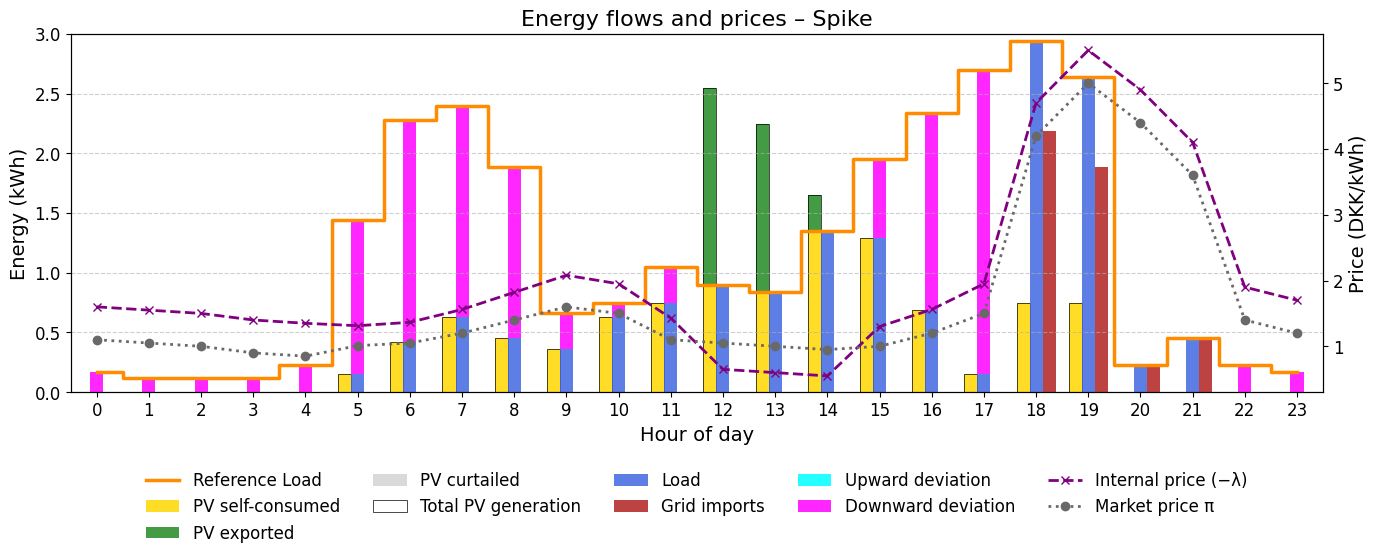

sum of load: 14.864999999999998


In [11]:
# --- Evening spike scenario ---
scenario_name = "Spike"
sc = scenarios[scenario_name]

# 1) Build input data
input_data = build_input_data_1b(base, sc)

# 2) Run optimization
problem = classes.LP_OptimizationProblem(input_data)
problem.run()

# 3) Convert results to DataFrame
df = helpers.results_to_dataframe(problem.results, base["T"])

# 4) Extract duals (λ_t for hourly balance constraints)
duals_lambda = [problem.results.duals[f"constr[{i}]"] for i in range(base["T"])]

num_constraints_before = 3 * base["T"] # (load balance + PV split + max load)
duals_delta = [problem.results.duals[f"constr[{i}]"] for i in range(num_constraints_before, num_constraints_before + base["T"])]

# 5) Plot
plots.plot_hourly_flows_with_prices_1b(
    df,
    scenario_name,
    duals=duals_lambda, # Use the correctly extracted duals
    price=sc["price"],
    alpha=sc["price"] + sc["imp"],
    beta=sc["price"] - sc["exp"],
    L_ref=base["L_ref"] 
)
print("sum of load:", df["l"].sum())

## 7. Comparative Analysis & Reporting

### Multi-Scenario Results Summary

Compare optimization results across all scenarios to understand:

**Key Metrics:**
- **Economic impact**: Total costs including discomfort penalties
- **Flexibility utilization**: Load deviation patterns and magnitudes
- **Market interaction**: Import/export volumes under different cost structures
- **Dual variable insights**: Shadow prices for deviation constraints (δₜ)

**Expected Insights:**
- **Trade-off analysis**: How discomfort costs limit purely economic optimization
- **Scenario sensitivity**: Which pricing structures most influence consumer behavior
- **Preference impact**: How reference load profiles shape optimal consumption
- **Flexibility value**: Economic benefits vs comfort costs of load shifting

The analysis includes both primal results (energy flows and deviations) and dual results (constraint shadow prices) to provide comprehensive understanding of the consumer's decision-making under preference constraints.

<class 'numpy.float64'> 0.0
<class 'numpy.float64'> 0.165
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 96 rows, 168 columns and 240 nonzeros
Model fingerprint: 0x9a6cebe6
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 87 rows and 143 columns
Presolve time: 0.01s
Presolved: 9 rows, 25 columns, 27 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4152845e+01   9.345000e+00   0.000000e+00      0s
       7    3.1840845e+01   0.000000e+00   0.000000e+00      0s

Solved in 7 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.184084500e+01
<class 'numpy.float64'> 0.0
<class 'numpy.float64'> 0.165
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[

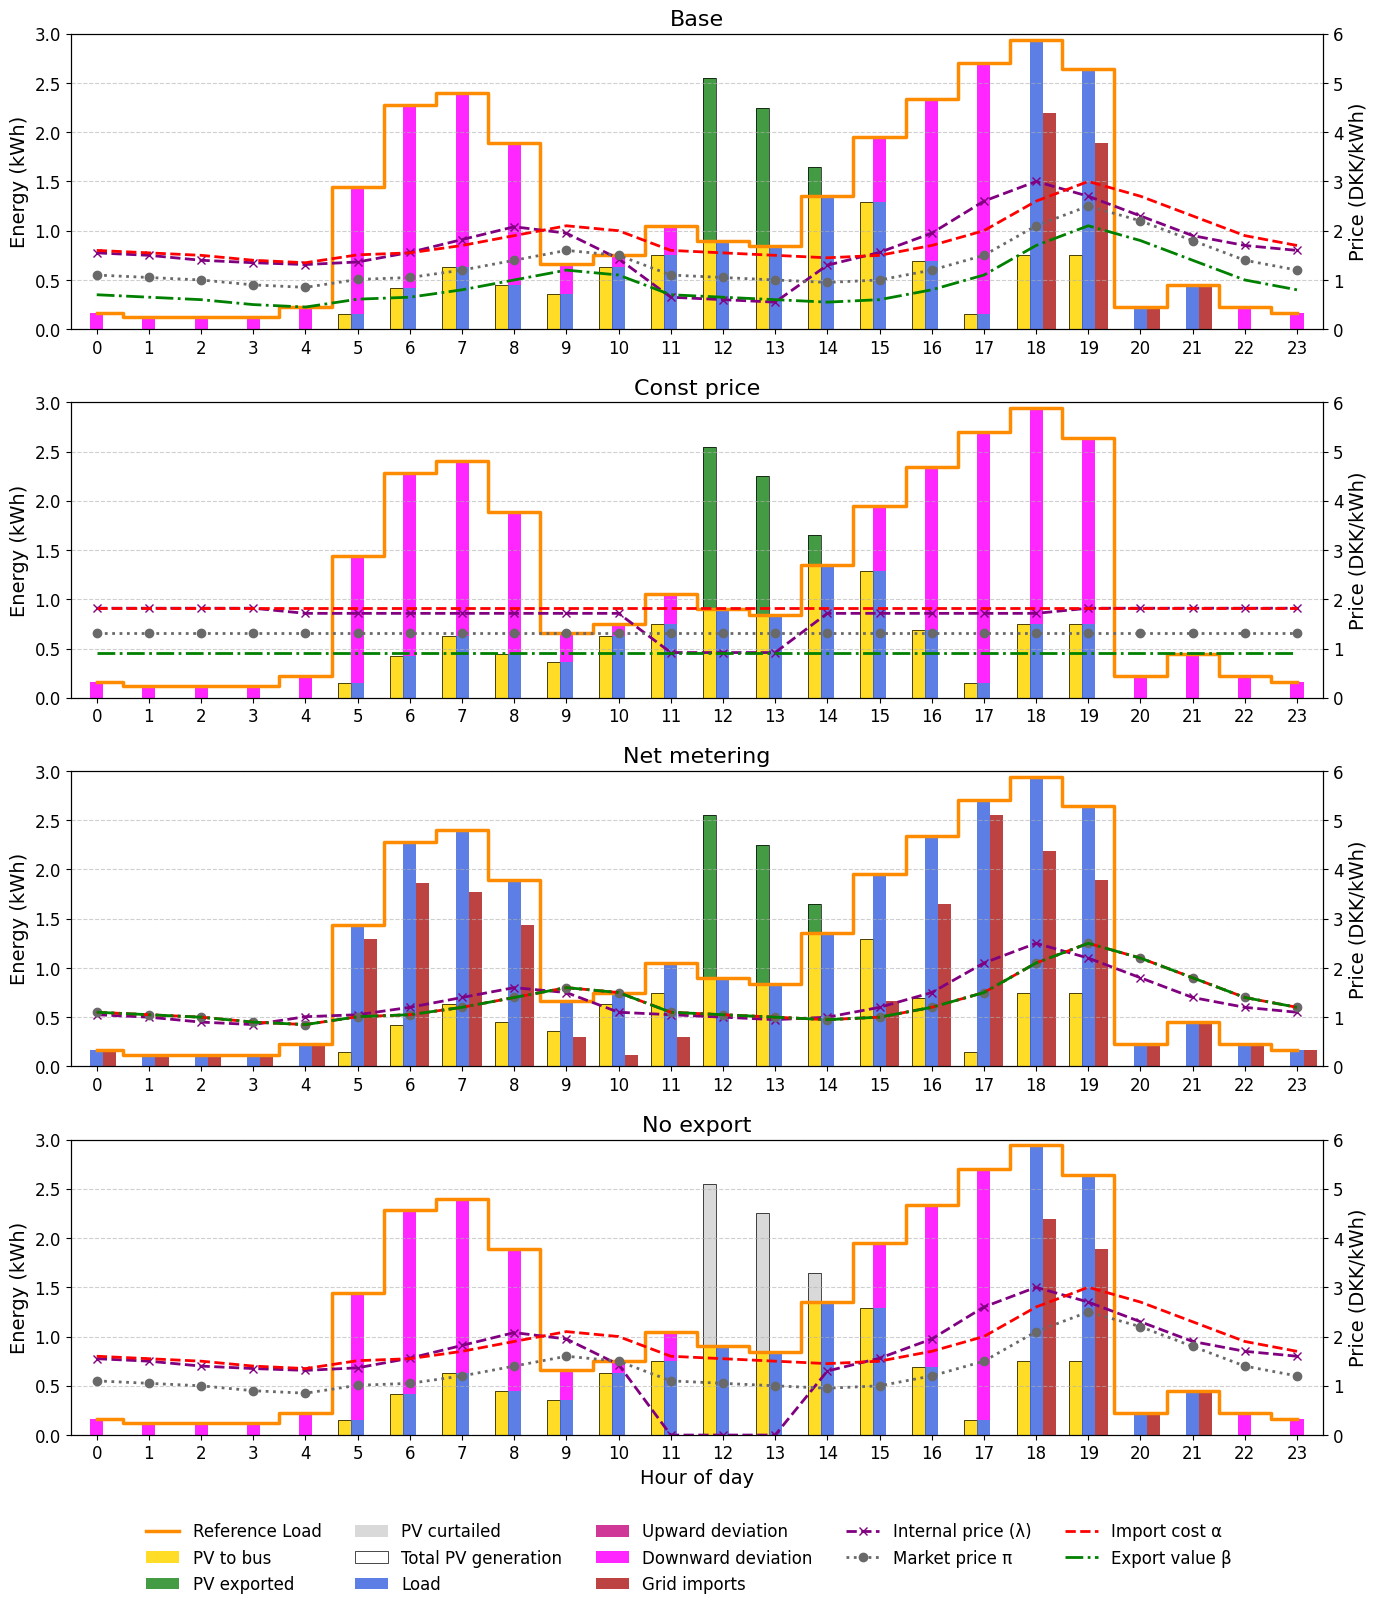

In [13]:
scenario_names = ["Base", "Const price", "Net metering", "No export", 
                  #"Spike"
                  ]

dfs, duals_list, price_list, alpha_list, beta_list, L_refs = [], [], [], [], [], []
results_summary = {}

for scenario_name in scenario_names:
    sc = scenarios[scenario_name]
    input_data = build_input_data_1b(base, sc)  # ⚡ must include battery vars
    problem = classes.LP_OptimizationProblem(input_data)
    problem.run()

    # --- Get results as DataFrame ---
    df = helpers.results_to_dataframe(problem.results, base["T"])

    if scenario_name == "Net metering":
        df = helpers.clean_net_metering_solution(df)

    dfs.append(df)

    # --- Store duals and prices ---
    duals = [problem.results.duals[f"constr[{i}]"] for i in range(1, base["T"]+1)]
    duals_list.append(duals)
    price_list.append(sc["price"])
    alpha_list.append(sc["price"] + sc["imp"])
    beta_list.append(sc["price"] - sc["exp"])
    L_refs.append(base.get("L_ref", None))  # optional reference load

    # --- Summaries ---
    mu = problem.results.duals.get("constr[0]", np.nan)
    lambdas = duals
    results_summary[scenario_name] = {
        "Objective": problem.results.objective_value,
        "Total import": df.get("e", pd.Series(0)).sum(),
        "Total export": df.get("s", pd.Series(0)).sum(),
        "Total curtailed": df.get("c", pd.Series(0)).sum(),
        "Total load": df.get("l", pd.Series(0)).sum(),
        "mu": mu,
        "lambda_mean": np.mean(lambdas),
        "lambda_min": np.min(lambdas),
        "lambda_max": np.max(lambdas),
    }

# --- Export summary table ---
df_results = pd.DataFrame(results_summary).T
print(df_results.to_latex(float_format="%.2f",
                          caption="Primal and dual results with battery by scenario",
                          label="tab:results_battery"))

# --- Plot all scenarios ---
plots.plot_scenarios_subplots_1b(
    dfs, scenario_names, price_list, alpha_list, beta_list, duals_list,
    L_ref_list=L_refs, ylim=(0,3)
)